In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["../src"]
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
#from black_it.calibrator import Calibrator
import pandas as pd
import calibration_simple_BC as cal_bc
from importlib import reload
from time import time
from itertools import product
import pandas as pd
from tqdm import tqdm

In [3]:
N, T, edge_per_t = 300, 1000, 5

epsilon, mu = 0.22, 0.2
rho = 70
epsilon_bounds = [[0.], [.5]]
precisions = [0.0001]

In [4]:
X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, seed = 1004, steepness = rho)
s_edges = np.concatenate(np.array(edges[:,:,2]))

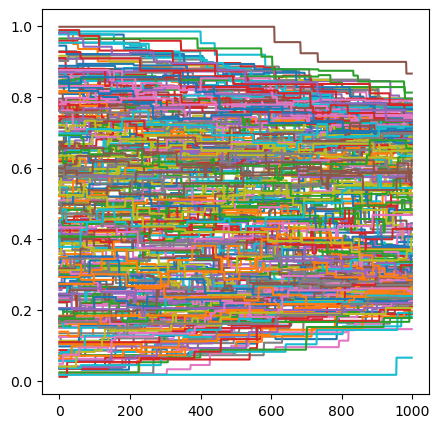

In [5]:
sim_bc.print_opinion_trajectory(X)

In [6]:
simulator_BC = cal_bc.BC_simulator_given_previous_time(X, edges, mu, epsilon)

In [7]:
s_pred = simulator_BC.simulate_s([0.55])

In [8]:
print("Same interaction sign", np.sum(np.abs(s_edges - (1 - s_pred))))
print("Different interaction sign", np.sum(np.abs(s_edges - s_pred)))

Same interaction sign 11786175.0
Different interaction sign 13163850.0


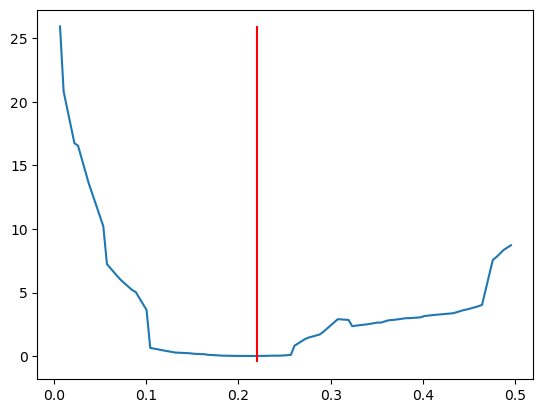

In [61]:
calibration = cal_bc.calibrate_epsilon_BC(simulator_BC, plot_loss = True, 
                                          precisions = [0.0001], calibration_batches = 10, return_time = True)


In [62]:
calibration["epsilon"], calibration["time"]

(0.21380000000000002, 3.577935218811035)

In [94]:
estimation_pgabm = est_bc.estimation_epsilon_torch(70, mu, X, edges, epsilon0 = 0.1, num_epochs = 2000, 
                                                   return_time = True, min_delta = 10e-6, patience = 50, lr = 0.005)


 14%|█████▎                                | 281/2000 [00:00<00:00, 1994.97it/s]


In [90]:
estimation_torch["epsilon"][-1], estimation_torch["time"]

(0.2044751003959226, 0.10750770568847656)

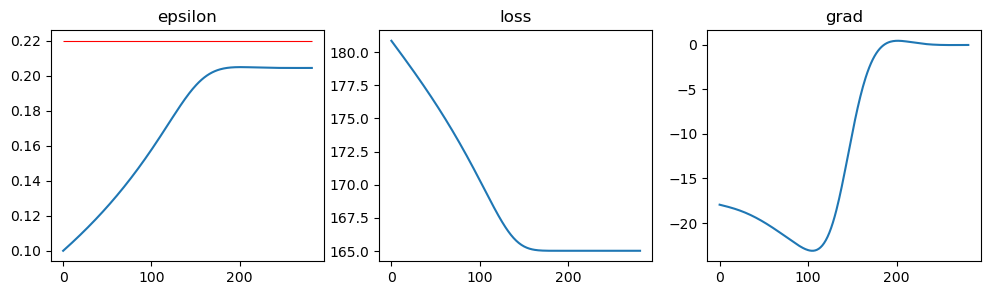

In [91]:
est_bc.print_history(estimation_torch, epsilon)

In [193]:
def compare_calibration_pgabm(N, T, edge_per_t, mu, epsilon, epsilon0, calibration_batches, compare_all_s = False):
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)
    simulator_BC = cal_bc.BC_simulator_given_previous_time(X, edges, mu, epsilon)
    calibration = cal_bc.calibrate_epsilon_BC(simulator_BC, plot_loss = False, compare_all_s = compare_all_s,
                                              precisions = [0.0001], calibration_batches = calibration_batches, return_time = True)
    estimation_pgabm = est_bc.estimation_epsilon_torch(rho, mu, X, edges, epsilon0, num_epochs = 2000, hide_progress = True,
                                                       return_time = True, min_delta = 10e-6, patience = 50, lr = 0.005)

    return {"N": N, "T": T, "edge_per_t": edge_per_t, "tot_edges": T * edge_per_t,
            "epsilon": epsilon, "epsilon0": epsilon0, "mu": mu,
            "epsilon_pgabm": estimation_pgabm["epsilon"][-1], "time_pgabm": estimation_pgabm["time"],
            "epsilon_calibration": calibration["epsilon"], "time_calibration": calibration["time"]
           }

def repeat_comparison_calibration_pgabm(N_list, T_list, edge_per_t_list, calibration_batches_list,
                                        repetitions = 1):
    
    simulations_comparison = []
    
    tot_sim = len(N_list) * len(T_list) * len(edge_per_t_list) * len(calibration_batches_list) * repetitions
    
    print("Total simulations", tot_sim)
    
    sim = 0
    for _, edge_per_t, N, T, calibration_batches in (product(np.arange(repetitions),
                                                             edge_per_t_list,
                                                             N_list, T_list, calibration_batches_list)):
        
        sim += 1
        print("Simulation", sim)
        epsilon = np.random.random() / 2
        epsilon0 = np.random.random() / 4 + 0.25
        mu = np.random.random() * min(1, 2000 / (T * edge_per_t))
        
        for compare_all_s in [True, False]:
            comparison = compare_calibration_pgabm(N, T, edge_per_t, mu, epsilon, epsilon0,
                                                   calibration_batches, compare_all_s)
            
            simulations_comparison.append(comparison)
            
    return pd.DataFrame(simulations_comparison)

In [ ]:
repeated_comparisons = repeat_comparison_calibration_pgabm([int(u) for u in np.logspace(2, 3, num = 4)], 
                                                           [int(u) for u in np.logspace(2, 3, num = 4)], 
                                                           [1, 2, 5], 
                                                           [10, 20, 50], repetitions = 5)

Total simulations 720
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17


In [12]:
#repeated_comparisons.to_csv("../data/comparison_calibration_pgabm_simpleBC_230309.csv")
repeated_comparisons = pd.read_csv("../data/comparison_calibration_pgabm_simpleBC_230309.csv", index_col = 0)


In [257]:
indexes = np.array(repeated_comparisons.index)

repeated_comparisons = repeated_comparisons.assign(distance_pgabm_real = lambda x: np.abs(x["epsilon_pgabm"] - x["epsilon"]),
                                                   distance_calibration_real = lambda x: np.abs(x["epsilon_calibration"] - x["epsilon"]),
                                                   compare_all_s = indexes % 2 == 0,
                                                   calibration_batches = [[10, 20, 50][u] for u in ((indexes / 2) % 3).astype(int)]                                                   
                                                  )

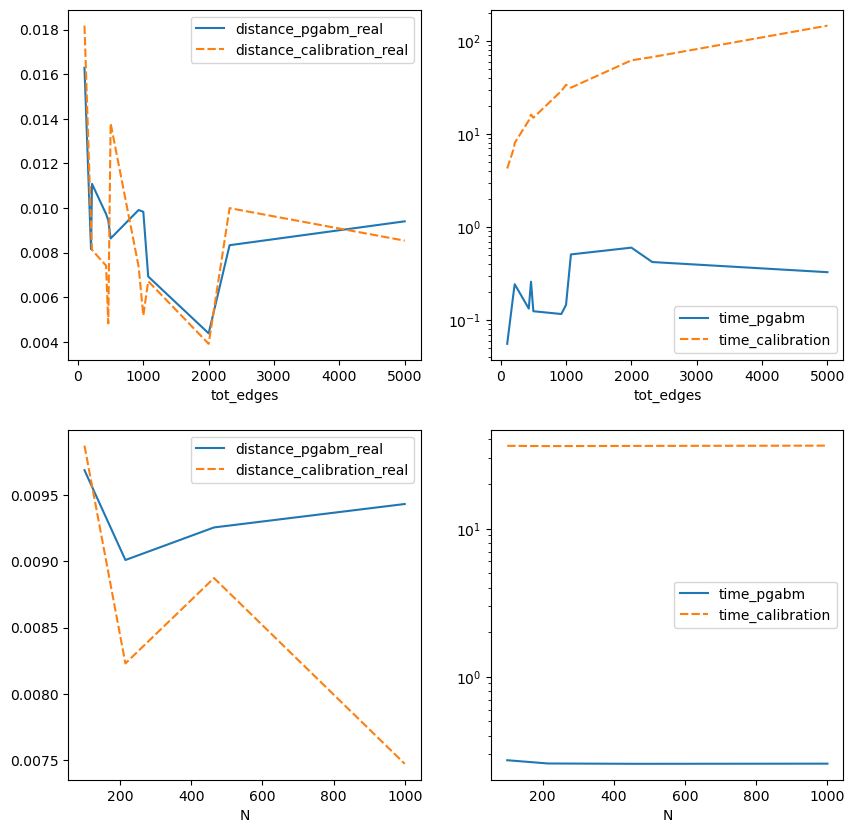

In [299]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = [10,10])

sns.lineplot(data = repeated_comparisons.groupby("tot_edges").mean()[["distance_pgabm_real", "distance_calibration_real"]], ax = axes[0,0])
sns.lineplot(data = repeated_comparisons.groupby("tot_edges").mean()[["time_pgabm", "time_calibration"]], ax = axes[0,1])
sns.lineplot(data = repeated_comparisons.groupby("N").mean()[["distance_pgabm_real", "distance_calibration_real"]], ax = axes[1,0])
sns.lineplot(data = repeated_comparisons.groupby("N").mean()[["time_pgabm", "time_calibration"]], ax = axes[1,1])
axes[0,1].set_yscale("log")
axes[1,1].set_yscale("log")


In [270]:
pd.DataFrame(repeated_comparisons.groupby("calibration_batches").mean()["distance_calibration_real"].T)

,distance_calibration_real
calibration_batches,
10,0.009188
20,0.008825
50,0.007824


<AxesSubplot:xlabel='compare_all_s', ylabel='time_calibration'>

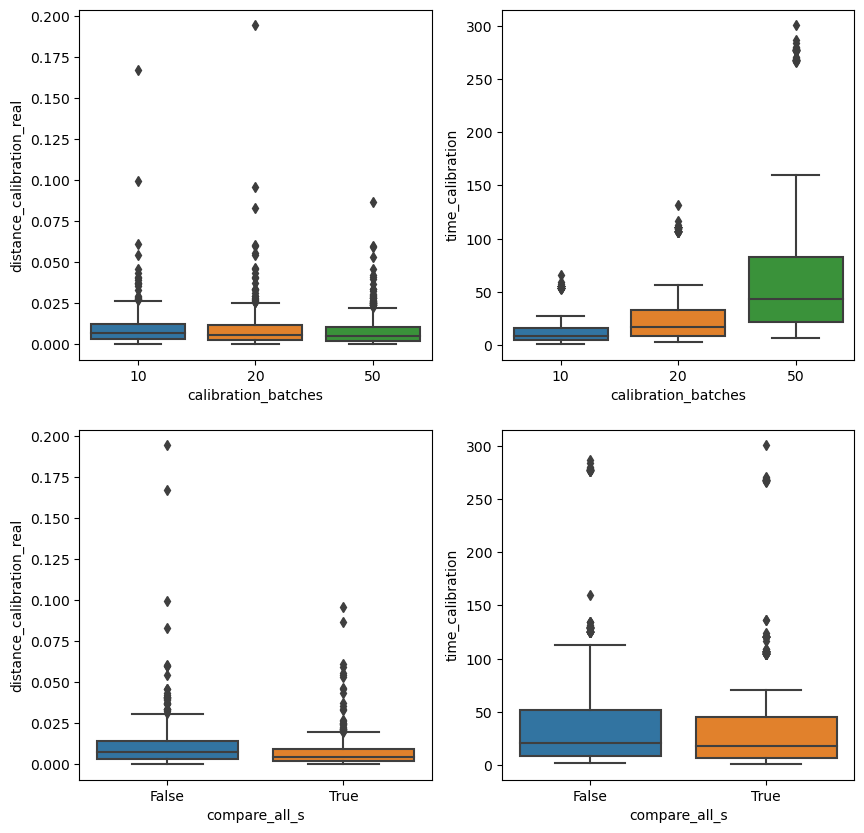

In [287]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = [10,10])

sns.boxplot(data = repeated_comparisons, x = "calibration_batches", y = "distance_calibration_real", ax = axes[0,0])
sns.boxplot(data = repeated_comparisons, x = "calibration_batches", y = "time_calibration", ax = axes[0,1])
sns.boxplot(data = repeated_comparisons, x = "compare_all_s", y = "distance_calibration_real", ax = axes[1,0])
sns.boxplot(data = repeated_comparisons, x = "compare_all_s", y = "time_calibration", ax = axes[1,1])




In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols = 2, nrows = 1, figsize = [10,5])

sns.lineplot(data = repeated_comparisons.groupby("tot_edges").mean()[["distance_pgabm_real", "distance_calibration_real"]], ax = ax0)


In [213]:
repeated_comparisons.columns

Index(['N', 'T', 'edge_per_t', 'tot_edges', 'epsilon', 'epsilon0', 'mu',
       'epsilon_pgabm', 'time_pgabm', 'epsilon_calibration',
       'time_calibration', 'distance_pgabm_real', 'distance_calibration_real'],
      dtype='object')